# Pancreas multi-technology, multi-species mapping
Last updated June 3, 2021

This notebook builds a reference of pancreatic islet cells then maps a separate query dataset.

In [1]:
suppressPackageStartupMessages({
    source('../R/libs.R') # imports
    source('../R/utils.R') # useful functions
})

In [18]:
celltype.colors = c('alpha'="#ed2bb1",
                    'beta'="#239eb3",
                    'gamma'="#d1bfec",
                    'delta'= "#FF6347",
                    'stellate'="#11e38c",
                    'immune'="#812050",
                    'ductal'="#b2d27a",
                    'endothelial'="#4e2da6",
                    'acinar'="#f6bb86",
                    'schwann'="#115d52",
                    'epsilon'="#a1def0")

gray = '#BEBEBE'

celltype.gray = c('alpha'=gray,
                    'beta'=gray,
                    'gamma'=gray,
                    'delta'=gray,
                    'stellate'=gray,
                    'immune'=gray,
                    'ductal'=gray,
                    'endothelial'=gray,
                    'acinar'=gray,
                    'schwann'=gray,
                    'epsilon'=gray,
                    'mast'=gray)

dataset.colors = c('celseq' = '#8796ad',
                   'celseq2' = '#add7d9',
                   'smartseq' = '#bbd1a5',
                   'c1' = '#d9cfad')

querydonor.colors = c('human1' = '#b9dbf0',
                      'human2' = '#77a1ba',
                      'human3' = '#6c7ca8',
                      'human4' = '#364261',
                      'mouse1' = '#e68c8c',
                      'mouse2' = '#b35757')

querydonor.colors2 = c('human 1' = '#b9dbf0',
                      'human 2' = '#77a1ba',
                      'human 3' = '#6c7ca8',
                      'human 4' = '#364261',
                      'mouse 1' = '#e68c8c',
                      'mouse 2' = '#b35757')

batchnn.colors = c('celseq' = '#8796ad',
                   'celseq2' = '#add7d9',
                   'smartseq' = '#bbd1a5',
                   'c1' = '#d9cfad',
                   'human1' = '#b9dbf0',
                      'human2' = '#77a1ba',
                      'human3' = '#6c7ca8',
                      'human4' = '#364261',
                      'mouse1' = '#e68c8c',
                      'mouse2' = '#b35757')

tf.colors = c('TRUE' = '#29c489',
              'FALSE' = '#ed4f1a')

# Build Symphony reference from plate-based datasets
Normalized and quality controlled expression matrix from 4 reference datasets obtained from Harmony paper (Korsunsky et al. 2019).

In [3]:
# Read in reference expression and metadata
exprs_norm = readRDS('../data/Fig4_pancreas_multi/reference_four_exp.rds')
metadata = readRDS('../data/Fig4_pancreas_multi/reference_four_metadata.rds')
dim(exprs_norm)

# Variables to integrate over are 'dataset (technology)' and 'donor'
length(unique(metadata$donor))
table(metadata$dataset)

[1] 15369  5887

[1] 32


      c1   celseq  celseq2 smartseq 
     625      946     2238     2078 

In [4]:
metadata %>% head(4)

,cell_id,dataset,technology,batch,nGene,percent_mito,status,donor,batch_orig,cell_type,cell_subtype
,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,celseq_D2ex_1,celseq,plate,celseq,1968,0,,D2,celseq,acinar,acinar
2,celseq_D2ex_2,celseq,plate,celseq,2627,0,,D2,celseq,acinar,acinar
3,celseq_D2ex_3,celseq,plate,celseq,1968,0,,D2,celseq,acinar,acinar
4,celseq_D2ex_4,celseq,plate,celseq,4097,0,,D2,celseq,ductal,ductal


Variable gene selection

In [5]:
# Select and subset expression by variable genes
var_genes = vargenes_vst(exprs_norm, groups = as.character(metadata$dataset), topn = 1000)
exprs_norm_vargenes = exprs_norm[var_genes, ]
message(paste0('Using ', nrow(exprs_norm_vargenes), ' vargenes'))

Using 2236 vargenes



Scaling and PCA

In [6]:
# Calculate and save the mean and standard deviations for each gene
vargenes_means_sds = tibble(symbol = var_genes, mean = Matrix::rowMeans(exprs_norm_vargenes))
vargenes_means_sds$stddev = singlecellmethods::rowSDs(exprs_norm_vargenes, vargenes_means_sds$mean)
    
## Scale data
exp_scaled = singlecellmethods::scaleDataWithStats(exprs_norm_vargenes, vargenes_means_sds$mean, 
                                                        vargenes_means_sds$stddev, 1)
## Run SVD, save gene loadings (s$u)
set.seed(0)
s = irlba(exp_scaled, nv = 20)
Z_pca = diag(s$d) %*% t(s$v) # [pcs by cells]
loadings = s$u

Harmony integration

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony converged after 5 iterations



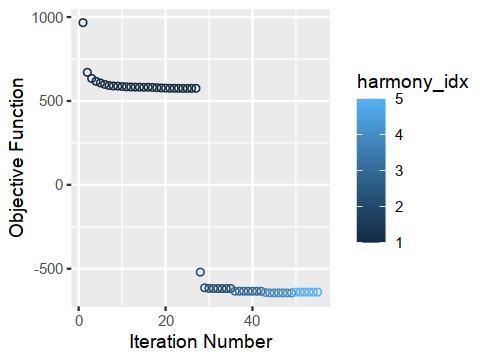

In [7]:
# Run Harmony
set.seed(0)
fig.size(3, 4)
harmObj = harmony::HarmonyMatrix(
        data_mat = t(Z_pca),              ## PCA embedding matrix of cells
        meta_data = metadata,             ## dataframe with cell labels
        theta = c(2, 4),                  ## cluster diversity enforcement
        vars_use = c('donor', 'dataset'), ## variable to integrate out
        nclust = 100,                     ## number of clusters in Harmony model
        max.iter.harmony = 10,
        tau = 5,
        return_object = TRUE,             ## return the full Harmony model object
        do_pca = FALSE,                    ## don't recompute PCs
        plot_convergence = TRUE
)


Build Symphony reference

In [8]:
reference = symphony::buildReferenceFromHarmonyObj(
                           harmObj,            # output object from HarmonyMatrix()
                           metadata,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = FALSE)

Save metadata, vargenes (S), and loadings (U)

Save R, Z_orig, Z_corr, and betas from Harmony object

Calculate final L2 normalized reference centroids (Y_cos)

Calculate reference compression terms (Nr and C)

Finished nicely.



UMAP embedding

In [26]:
set.seed(1)
umap <- uwot::umap(
        t(reference$Z_corr), n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .3, n_threads = 4, ret_model = TRUE)
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(reference$meta_data, umap$embedding)

In [27]:
# Save UMAP model
save_uwot_path = '/data/srlab2/jkang/symphony_reproducibility/pre-built_references/pancreas_plate-based_uwot_model'
model = uwot::save_uwot(umap, file = save_uwot_path, unload = FALSE, verbose = FALSE)
save_uwot_path = '../pre-built_references/pancreas_plate-based_uwot_model'
reference$save_uwot_path = save_uwot_path

Warning message:
“invalid uid value replaced by that for user 'nobody'”


Due to how uwot was designed, the uwot model must be saved as a separate file. Therefore,
in order to map to the reference and visualize with reference UMAP coordinates, 
you need to update the `reference$save_uwot_path` with the path to the desired uwot model.
i.e. replace `../pre-built_references/pancreas_uwot_model` with your own path.

In [28]:
# Save UMAP coordinates
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
reference$umap = umap

Save Symphony reference

In [29]:
saveRDS(reference, '../pre-built_references/pancreas_plate-based_reference.rds')

## Plot reference cells UMAP

In [30]:
# Read in saved reference
reference = readRDS('../pre-built_references/pancreas_plate-based_reference.rds')

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Adding missing grouping variables: `cell_subtype`



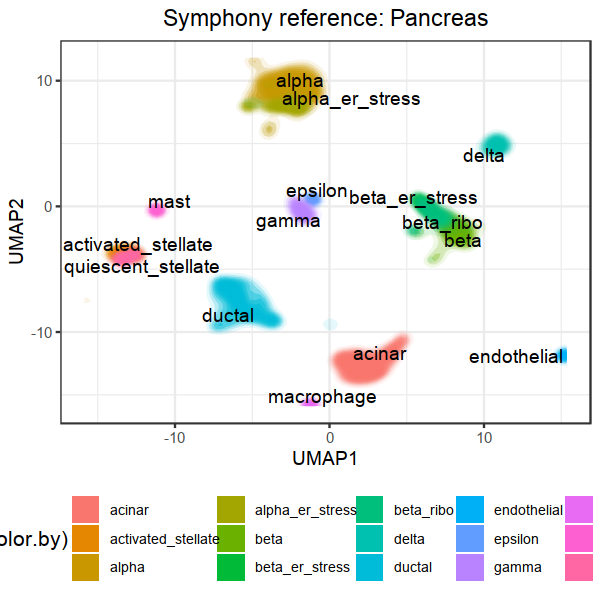

In [39]:
fig.size(5, 5)
p = plotReference(reference,
                   as.density = TRUE,      # plot density or individual cells
                   bins = 10,              # if density, nbins parameter for stat_density_2d
                   bandwidth = 1.5,        # if density, bandwidth parameter for stat_density_2d
                   title = "Symphony reference: Pancreas",    # Plot title
                   color.by = 'cell_subtype', # metadata column name for cell type labels
                   #celltype.colors = celltype.colors, # custom color palette
                   show.legend = TRUE,     # Show cell type legend
                   show.labels = TRUE,     # Show cell type labels
                   show.centroids = FALSE) # Plot soft cluster centroid locations)
p

# Map human and mouse query

## Set up cross-species mapping

The query dataset consists of pancreatic islet cells from 4 human and 2 mouse donors from Baron et al. (2016).


The mouse expression was "humanized" using a custom ortholog mapping (`../data/Fig4_pancreas_multi/ensembl_homologene_human-to-mouse_mapping.rds`) generated from combining ortholog pairs from Ensembl (accessed via biomaRt) and Homologene.

Obtained NCBI Homologene mapping from: https://ftp.ncbi.nih.gov/pub/HomoloGene/build37.2/homologene.data

In [32]:
# Read in normalized expression for human and mouse
human_exp_norm = readRDS('../data/Fig4_pancreas_multi/baron_human_exp.rds')
mouse_exp_norm = readRDS('../data/Fig4_pancreas_multi/baron_mouse_biomart_homologene_exp.rds')

# Read in metadata
human_metadata = readRDS('../data/Fig4_pancreas_multi/baron_human_metadata.rds')
mouse_metadata = readRDS('../data/Fig4_pancreas_multi/baron_mouse_metadata.rds')
human_metadata$species_donor = paste0(human_metadata$species, human_metadata$donor)
mouse_metadata$species_donor = paste0(mouse_metadata$species, mouse_metadata$donor)

In [33]:
dim(human_exp_norm)
human_metadata %>% head(4)
dim(mouse_exp_norm)
mouse_metadata %>% head(4)

[1] 20125  8569

,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
human1_lib1.final_cell_0001,1,acinar,3526,acinar,human,inDrop,human1
human1_lib1.final_cell_0002,1,acinar,4201,acinar,human,inDrop,human1
human1_lib1.final_cell_0003,1,acinar,2119,acinar,human,inDrop,human1
human1_lib1.final_cell_0004,1,acinar,2956,acinar,human,inDrop,human1


[1] 20873  1886

,donor,cell_type1,total_features,cell_type,species,dataset,species_donor
,<dbl>,<fct>,<int>,<fct>,<chr>,<chr>,<chr>
mouse1_lib1.final_cell_0001,1,beta,3205,beta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0002,1,ductal,3829,ductal,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0003,1,delta,2582,delta,mouse,inDrop,mouse1
mouse1_lib1.final_cell_0004,1,schwann,3041,schwann,mouse,inDrop,mouse1


In [34]:
human_exp_norm[1:5, 1:2]
mouse_exp_norm[1:5, 1:2]

5 x 2 sparse Matrix of class "dgCMatrix"
       human1_lib1.final_cell_0001 human1_lib1.final_cell_0002
A1BG                      .                                  .
A1CF                      1.024161                           .
A2M                       .                                  .
A2ML1                     .                                  .
A4GALT                    .                                  .

5 x 2 sparse Matrix of class "dgCMatrix"
         mouse1_lib1.final_cell_0001 mouse1_lib1.final_cell_0002
13CDNA73                           .                           .
15E1.2                             .                           .
182-FIP                            .                           .
3'HEXO                             .                           .
384D8-2                            .                           .

In [35]:
# To map the human and mouse simultaneously, combine the two sparse matrices
combined_filled <- t(plyr::rbind.fill.matrix(t(mouse_exp_norm), t(human_exp_norm)))
combined_filled[is.na(combined_filled)] = 0 # fill in any missing genes with 0
colnames(combined_filled) = c(rownames(mouse_metadata), rownames(human_metadata))

## Run Symphony mapping

In [36]:
# Mapping
system.time({
query= mapQuery(exp_query = combined_filled, 
                        metadata_query = rbind(mouse_metadata, human_metadata),
                        ref_obj = reference,
                        vars = c('dataset', 'species', 'species_donor'), 
                        do_normalize = FALSE)
})

Scaling and synchronizing query gene expression

Found 2236 reference variable genes in query dataset

Project query cells using reference gene loadings

Clustering query cells to reference centroids

Correcting query batch effects

UMAP

All done!



   user  system elapsed 
 13.455   5.234   9.364 

Plot query in reference UMAP coordinates

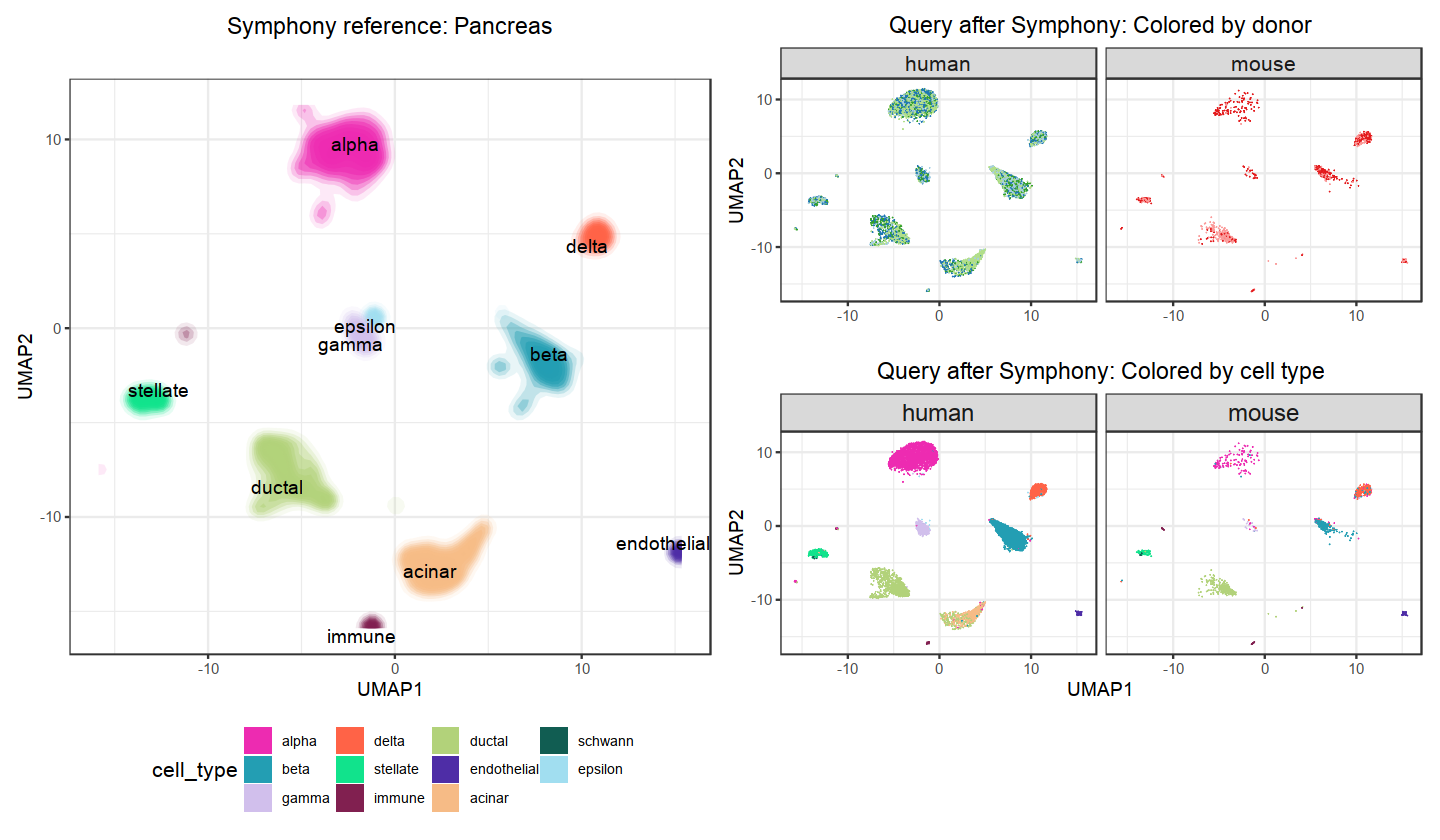

In [37]:
fig.size(7, 12)

# Add UMAP coordinates
colnames(query$umap) = c('UMAP1', 'UMAP2')
umap_labels = cbind(query$meta_data, query$umap)

# Plot UMAP visualization
p1 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = species_donor)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query after Symphony: Colored by donor', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none", legend.text = element_text(size=11), legend.title = element_text(size = 12)) +
    scale_colour_brewer(palette = 'Paired') +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    facet_wrap(~species, nrow=1) +
    theme(strip.text.x = element_text(size = 12)) + xlab('')

p2 = umap_labels %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = cell_type)) +
    geom_point_rast(size = 0.3, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query after Symphony: Colored by cell type', color = '') + 
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="none", legend.text = element_text(size=11), legend.title = element_text(size = 12)) +
    scale_colour_manual(values = celltype.colors) +
    guides(colour = guide_legend(override.aes = list(size = 3), ncol = 5)) +
    facet_wrap(~species, nrow=1) + 
    theme(strip.text.x = element_text(size = 14)) 

p | (p1 / p2)

Save results as single embedding for benchmarking

In [11]:
# Combine reference and query cell embeddings
mappingZ = rbind(t(query_combined$Z), t(reference$Z_corr))
rownames(mappingZ) = c(as.character(rownames(query_combined$meta_data)), 
                       as.character(reference$meta_data$cell_id))

# Expanded metadata for all query cells
mapping_meta = readRDS('../data/Fig4_pancreas_multi/all_meta.rds')

# Match cell order to metadata
mappingZ = mappingZ[order(match(rownames(mappingZ), rownames(mapping_meta))), ]

# Save Symphony mapping embedding
saveRDS(mappingZ, '../data/Fig4_pancreas_multi/mappingZ_Symphony.rds')

De novo UMAP

In [13]:
# Run de novo UMAP on mapping of cells
set.seed(0)
umap <- uwot::umap(
        mappingZ, n_neighbors = 30, learning_rate = 0.5, init = "laplacian", 
        metric = 'cosine', fast_sgd = FALSE, n_sgd_threads = 1,
        min_dist = .3, n_threads = 4, ret_model = TRUE)
colnames(umap$embedding) = c('UMAP1', 'UMAP2')
all_meta = cbind(mapping_meta, umap$embedding)

Plot mapping

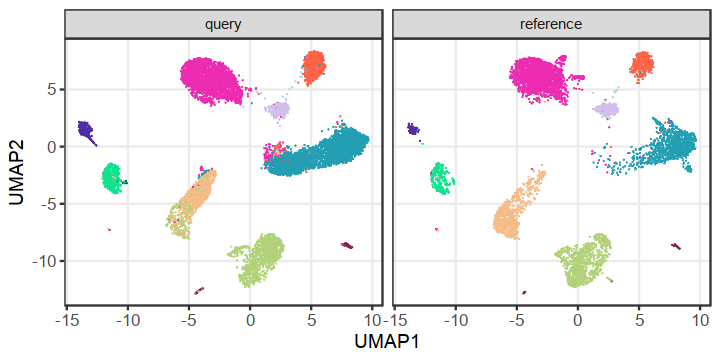

In [39]:
fig.size(3, 6)
q = all_meta %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) +
    geom_point_rast(aes(color = cell_type), size = 0.2, shape = 16) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) + 
    scale_color_manual(values = celltype.colors) +
    theme(legend.position="none") +
    theme(axis.text=element_text(size=10)) + xlab('UMAP1') + ylab('UMAP2') +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), 
          legend.title=element_text(size=14)) + 
    guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5)) + facet_wrap(~ref_query)
q

## Other plots

### Speed comparison

In [3]:
d = data.frame(Method = c('Symphony', 'Seurat', 'scArches'), elapsed_time = c(1.406, 31.66, 381.5))

In [4]:
d

Method,elapsed_time
<fct>,<dbl>
Symphony,1.406
Seurat,31.660
scArches,381.500


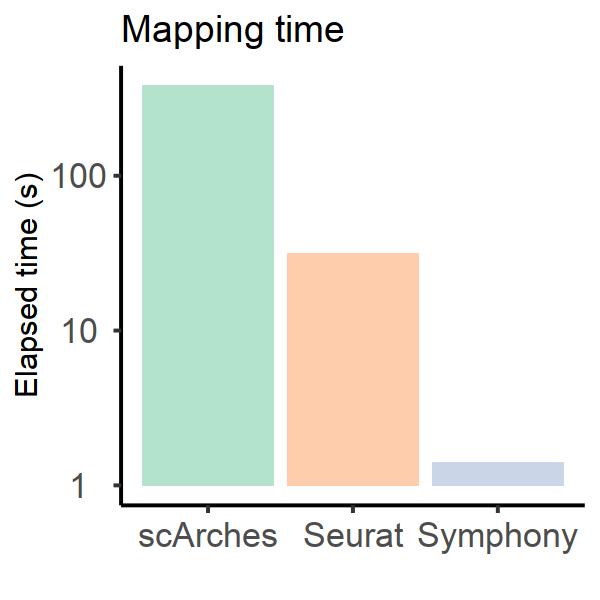

In [36]:
fig.size(3,3)
options(repr.plot.res = 200)
d %>% ggplot() +
        geom_col(aes(x = Method, y = elapsed_time, fill = Method)) + 
        scale_y_log10() +
        ylab('Elapsed time (s)') + xlab('') +
        ggtitle('Mapping time') +
        theme_classic() +
        scale_fill_brewer(palette = 'Pastel2') +
        theme(legend.position = 'none') +
        theme(axis.text.x = element_text(size = 12, hjust = .5, vjust = .5, face = "plain")) + 
        theme(axis.text.y = element_text(size = 12, hjust = .5, vjust = .5, face = "plain"))
        